# Bloom Filters
## 1. supported operations and use cases
Bloom filters are a data structure that remembers which elements have been seen before and which ones have not, using very little space. For this, it does not store any data directly, but rather consists of many boolean values that are turned to 1 when an element is "inserted". Every element will have a few hash functions that determine which elements of the bloom filter to turn to true, if an element is already true, it will not change how the function works. This also means insert runs at constant time.<br> To look up an element, one simply has to hash the element and check all the corresponding positions in the bloom filter. This also runs in positive time complexity.<br> Two potential downsides of bloom filters are the fact that the "delete" operation is not supported, and the existence of "phantom elements" that will cause a false positive rate.$^1$ Since we are not keeping track of which elements turned a position to True, we might search an element and think it is there because other elements turned all of its hash functions to true.<br> 
In summary, the supported operations are:
1. insert
2. search

There are variations of bloom filters that also support deletion, but this exploration will focus on the classic case.<br>
Use cases:<br>
Bloom filters are useful for any situations where memory usage is expensive and the downsides of not being able to delete elements and having the possibility of false positives is not significant. Some examples are Medium keeping track of which articles a reader has already visited so they do not appear in the recommendations, or Google Chrome using Bloom filters to identify malicious URLs (used to).(Roughgarden, 2017)<br>

## 2. Implementation of a Bloom Filter

In [2]:
!pip install mmh3
!pip install bitarray


  Running setup.py bdist_wheel for mmh3 ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/38/b4/ea/6e4e321c625d3320c0c496bf4088371546d8fce5f1dd71b219
Successfully built mmh3
  Running setup.py bdist_wheel for bitarray ... - \ done
  Stored in directory: /root/.cache/pip/wheels/5f/33/3c/1370189fedb8fbb2c3297388cc8cdbe2af0efb48941cf8d526
Successfully built bitarray


In [0]:
import mmh3 # importing the mmh3 hashing functions
from bitarray import bitarray # importing the bitarray structure

class bloomfilter(object):
  
    # initializing a bloom filter with size n and n_hash hash functions
    def __init__(self,length,n_hash):
        # the size of the bloomfilter is n
        self.length=length 
        # sets an element equal to n_hash
        self.n_hash=n_hash 
         # creates a bitarray of size n
        self.bits=bitarray(length) 
        # sets all the elements in the bitarray to zero
        self.bits.setall(0) 
        
    # function to insert elements in the bloomfilter
    def insert(self,elem): 
        # for as many different seeds as there are hash functions
        for seed in range(self.n_hash):
            # set the bits at the postion determined by murmurhash equal to 1
            self.bits[mmh3.hash(elem,seed)%self.length]=1
            
    # function to search elements in the bloomfilter
    def search(self,elem): 
        # iterating through n_hash hash function
        for seed in range(self.n_hash): 
            # using different seeds and adjusting for the length of the list
            if self.bits[mmh3.hash(elem,seed)%self.length]==0: 
                # return false if the element is not in the bloom filter
                return False  
        # return true if it is
        return True   
      
      
      #HC-tag 2

In [35]:
### Demonstration of bloomfilter ###

# initialization: a bloomfilter with 2 functions and a bitarray size 10
x=bloomfilter(10,2)
# inserting a string
x.insert("Hello")
print("After inserting 'Hello', the Blooom Filter looks like this:",x.bits)
# inserting another string
x.insert("World")
print("After inserting 'World', the bloomfilter looks like this:",x.bits)
# searching "Hello" in x
print("When searching 'Hello', we get:",x.search("Hello"))
# searching "Hello World
print("When searching 'Hello World', we get:",x.search("Hello World"))

After inserting 'Hello', the Blooom Filter looks like this: bitarray('1010000000')
After inserting 'World', the bloomfilter looks like this: bitarray('1011000000')
When searching 'Hello', we get: True
When searching 'Hello World', we get: False


Above, we may notice how there is only one additional 1 in the bitarray after we insert the second word. This means one of the hash functions evaluates to the same value. This kind of overlap leads to false positives.

## 3. Description of the Hash Function used
Murmurhash 3 (mmh3) is a non-cryptographic hashfunction created by Austin Appleby. The name is composed of mu(ltiplication) and r(otation), which are used in the function itself.<br>
I chose this function because it is a fairly standard and efficient algorithm, that passes basic tests like the avalanche test or the chi-squared test.(Appleby, 2011)<br>
To quickly summarize what the function actually does: it takes every 32-bit piece (e.g.4 letters) and shifts them by 8, 16 or 24 bytes depending on their position. We then assign the resulting value to a variable and *mu*ltiply them with different constants, then *r*otating them so the most significant bits become the least significant ones and all the others become more important. There are more details on how to deal with remaining bytes and a final avalanche, that I will not explain here. (Sahib Yar, 2017) It may seem like a complicated algorithm, butthe algorithm compiles down to 52 instructions on a x86 machine (Appleby, 2011), which is incredibly fast for such an efficient algorithm.

In [5]:
### Avalanche test ###
# shows that with changing a single bit, the output changes dramatically
print("mmh3.hash('abd',123)=",mmh3.hash("abd",123))
print("mmh3.hash('abe',123)=",mmh3.hash("abe",123))

mmh3.hash('abd',123)= 454173339
mmh3.hash('abe',123)= -209095228


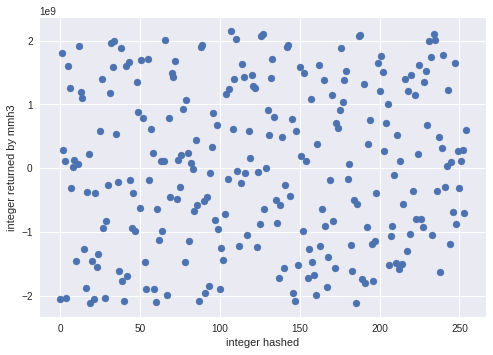

In [36]:
### visual representation of the Chi-squared test ###
# the elements are distributed evenly across the range of values (on the y-axis)
# this plot also shows that consecutive numbers, represented as bytes,
# hash to very different outputs
from matplotlib import pyplot as plt
import numpy as np
y= [mmh3.hash(bytes([i]),2) for i in range(255)]
x= [i for i in range(255)]
plt.scatter(x,y)
plt.xlabel("integer hashed")
plt.ylabel("integer returned by mmh3")
plt.show()

# HC-tag 3

## 4. Analysis of scaling
### 4.1. In terms of memory size as a function of the false positive rate<br>
In my implementation, the false positive rate p is not directly given, but rather determined by the number of elements stored n, the number of hash functions k, and the size of the bitarray m.<br>
$p=(1-e^{\frac{-kn}{m}})^k$<br>
The size of the bitarray is a good measure of the memory size and to relate it to the false positive rate, I can rewrite the function above to return the arraysize m a given false positive rate p, number of inserted elements n and number of hash functions k.<br>
$m=-kn/ln(1-p^{\frac{1}{k}})$<br>
To optimize further, we can pre-determine the optimal value of k for a given array size and number of elements as <br>$k=\frac{m}{n ln2}$<br>Technically, k needs to be a positive integer, but we will ignore that for now and put it back into the code.<br>
Plugging the function for k back into our function for m, we get that 
<br>$m=-\frac{nlnp}{(ln2)^2}$
<br> we can now use the function for the size depending on the false positive rate and plot them with a constant number of elements.
<br> To be very thorough, I will additionally define a function that returns the optimal number of hash functions and use my implementation of a bloomfilter to make a version that takes the desired false positive rate and number of elements and creates a corresponding bloomfilter.

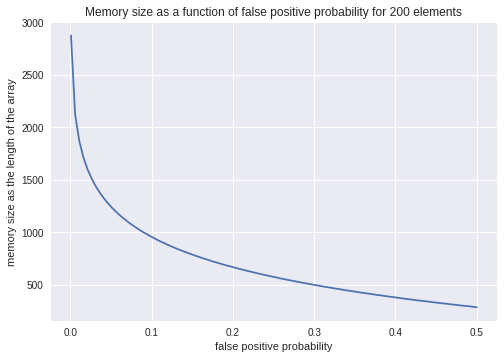

In [74]:
### plotting memory size as a function of the false positive rate ###
import math
import numpy as np

#defining a function that returns the array size given p and n
def array_size(p,n): 
  return -(n*math.log(p)/(math.log(2))**2)//1 #//1 to make sure it is an integer

# setting the input objects to 200
n=200

# plot the array size as a function of p
y=[array_size(p,n) for p in np.linspace(0.001,0.5,100)]
x=[p for p in np.linspace(0.001,0.5,100)]
plt.plot(x,y)
plt.title("Memory size as a function of false positive probability for 200 elements")
plt.xlabel("false positive probability")
plt.ylabel("memory size as the length of the array")
plt.show()

### 4.2 In terms of memory size as a function of the number of items stored <br>


In [0]:
# define a function that returns the optimal number of hash functions given p&n
def hash_functions(p,n):
  return 1+(array_size(p,n)/(n*math.log(2)))//1


# define a function that creates a bloomfilter with a specified number of inputs
# and false positive rate
def p_n_bloomfilter(p,n):
  return bloomfilter(array_size(p,n),hash_functions(p,n))


### 4.3 In terms of access time as a function of the false positive rate<br>
The most relevant answer to this question is that a bloomfilter with a predetermined size and number of access functions, the false positive rate will not influence the access time. Instead it will be order O(k), where k is a constant equal to the number of access items.<br>
To make it more interesting, I will however assume that the size of the array changes to adjust to the false positive rate with a set number of elements n.<br>
Using our "hash_functions" function, we can easily plot the access time depending on the false positive rate with a constant value for n. 
<br>
 We notice that the function of k is not continous since it can only take positive integer values, and decays as p increases.<br>
<br>
We notice that the value never drops below 1, since we need at least 1 hash-function.
<br>


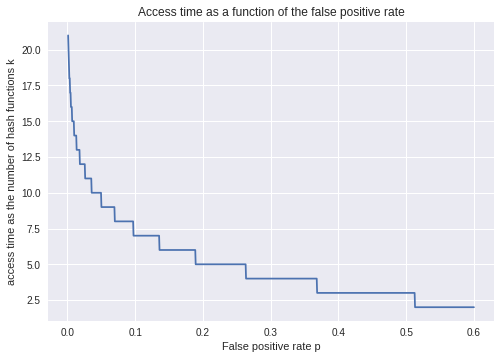

In [85]:
# set the number of inserted elements equal to 200 
n=200

# get the optimal number of hash functions for this number of elements given n&m
y=[hash_functions(p,n) for p in np.linspace(0.001,0.6,1000)]
# the values of p we iterated over
x=[p for p in np.linspace(0.001,0.6,1000)]
# make a plot of the two parameters
plt.plot(x,y)
plt.title("Access time as a function of the false positive rate")
plt.xlabel("False positive rate p")
plt.ylabel("access time as the number of hash functions k")
plt.show()

### 4.4. In terms of access time as a function of the number of items stored<br>
As in 4.3, the complexity of the access operation is still O(k), where k is a constant.<br>
So let's look at the very interesting case of a bloomfilter that automatically adjusts to other requirements:<br>
From the collection of functions in part 1, we are tempted to predict the behavior from:<br>
$k=\frac{m}{n ln2}$<br>
n is in the denominator of the fraction, so we expect a decaying function. 
<br> However, To adjust for the size of the array, m will also be adjusted. Under this assumption, we will reach the maximum number of functions for a given value of p rather quickly, after which, the function will be a constant, as expected. The example plotted below is for p=0.1

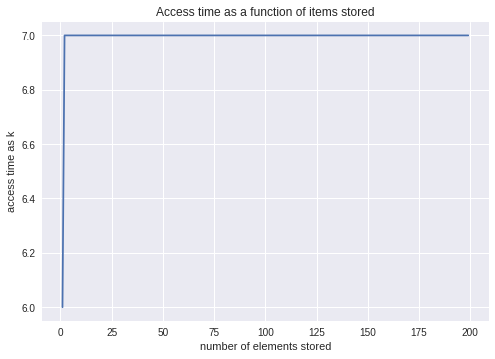

In [98]:
# set the false positive rate
p=0.1
# plot the required number of hash functions with array size n
y=[hash_functions(p,n) for n in range(1,200)]
x=[n for n in range(1,200)]
plt.plot(x,y)
plt.title("Access time as a function of items stored")
plt.xlabel("number of elements stored")
plt.ylabel("access time as k")
plt.show()

## 5. Comparison of theoretical false positive rate and implementation's false positive rate
To test the practical false positive rate of the function, we need to generate inputs to test this. First, I will generate a list of 10,000 randomly generated strings containing letters, punctuation and numbers (between 8 and 50 of them). Then I will slowly increase the number of letters that are in the bloom filter and try all the other letters that should not be in the bloom filter. I will keep count of how many of those searches return true and get the percentage of the total. On the same plot, I will show the expected value of the false positive rate with the same array size and number of inserted elements. As we see below, the implementation's false positive rate (red) closely follows the actual false positive rate(blue). Of course, we could also choose m as the x-axis with a constant n.

In [0]:
import string
from random import *


characters = string.ascii_letters + string.punctuation + string.digits
words = ["".join(choice(characters) for x in range(randint(8,50))) for i in range(10000)]

$p=(1-e^{\frac{kn}{m}})^k$

In [0]:
# setting length and number of bloomfilters 
m=1000
k=3
# initializing bloomfilter
x=bloomfilter(m,k)
# empty list to collect the false positive rates
y=[]
# iterate through 1200 insertions
for i in range(1200):
  x.insert(words[i])
  true_count=0
  total=1
# measure the false positive rate for each insertion
  for j in range(i,len(words)):
    if x.search(words[j])==False:
      total+=1
    else:
      true_count+=1
      total+=1
  y.append(true_count/total)
  
# calculate the theoretical values over the same range

t=[(1-math.exp(-k*n/m))**k for n in range(1200)]



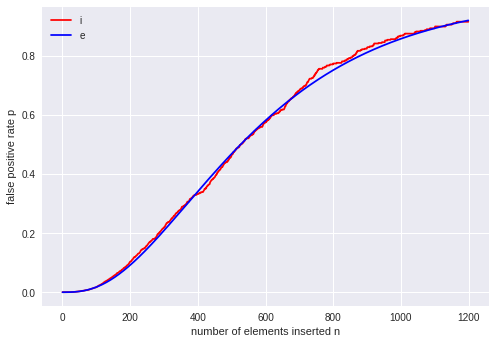

In [109]:
# plot the implementation's false positive rate as a function of elements
# inserted in a bloomfilter of length 1000, with 3 hash functions
n=[n for n in range(1200)]
plt.plot(n,y,"r")
plt.plot(n,t,"b")
plt.legend("ie")
plt.xlabel("number of elements inserted n")
plt.ylabel("false positive rate p")
plt.show()

## Sources:
Appleby, A. (2011). murmurhash. Retrieved November 13, 2018, from https://sites.google.com/site/murmurhash/
<br>
Roughgarden, T. (2017, January 27). 16 1 Bloom Filters The Basics 16 min - YouTube. Retrieved November 8, 2018, from https://www.youtube.com/watch?v=zYlxP7F3Z3c <br>
Sahib Yar. (2017). Murmur Hash - Explained. Retrieved from https://www.youtube.com/watch?v=b8HzEZt0RCQ
<br>


## HC-Tags:
1. #algorithms: I implemented an efficient bloomfilter class, clearly annotating my code  <br>
2. #professionalism: I went the extra mile in visualizing the hash function as well as all the relations in part 4.<br>
3. #constraints: When introducing bloom filters, I give an explanation of their advantages and disadvantages and why working with the constraints is still beneficial.
